In [1]:
#Importing libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Embedding, Dropout
from sklearn import preprocessing
import datetime as dt

In [2]:
#Reading data
url = "https://hub.mph.in.gov/dataset/bd08cdd3-9ab1-4d70-b933-41f9ef7b809d/resource/afaa225d-ac4e-4e80-9190-f6800c366b58/download/covid_report_county_date.xlsx?raw=true"
cases_data = pd.read_excel(url)

# population_data = pd.read_csv(f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/indiana countywise population.csv")

population_data = pd.read_csv(f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/population density of indiana county.csv")

#Data preprocessing
population_data["County"] = population_data["County"].str.upper()
population_data["County"] = population_data["County"].str.replace('.', '')
population_data["County"] = population_data["County"].str.replace(' ', '')
cases_data["COUNTY_NAME"] = cases_data["COUNTY_NAME"].str.replace(' ','')

data = pd.merge(cases_data, population_data, how = 'inner', left_on = 'COUNTY_NAME', right_on = 'County')
data = data[["COUNTY_NAME", "DATE", "COVID_COUNT",  "COVID_DEATHS", "COVID_TEST", "Population", "Area", "Population Density"]]
data

,COUNTY_NAME,DATE,COVID_COUNT,COVID_DEATHS,COVID_TEST,Population,Area,Population Density
0,ADAMS,2020-02-29,0,0,0,34387.0,339,101.436578
1,ADAMS,2020-03-02,0,0,0,34387.0,339,101.436578
2,ADAMS,2020-03-03,0,0,0,34387.0,339,101.436578
3,ADAMS,2020-03-04,0,0,0,34387.0,339,101.436578
4,ADAMS,2020-03-05,0,0,1,34387.0,339,101.436578
...,...,...,...,...,...,...,...,...
11771,WHITLEY,2020-07-02,7,1,26,33292.0,336,99.083333
11772,WHITLEY,2020-07-03,2,0,16,33292.0,336,99.083333
11773,WHITLEY,2020-07-04,2,0,9,33292.0,336,99.083333
11774,WHITLEY,2020-07-05,0,0,1,33292.0,336,99.083333


In [3]:
data.describe()

,COVID_COUNT,COVID_DEATHS,COVID_TEST,Population,Area,Population Density
count,11776.000000,11776.000000,11776.000000,11776.000000,11776.000000,11776.000000
mean,4.129246,0.214334,45.013162,70436.967391,389.434783,177.640432
std,15.011207,0.912244,116.358373,116127.410000,95.500277,280.278628
min,0.000000,0.000000,0.000000,6128.000000,86.000000,21.807882
25%,0.000000,0.000000,3.000000,21494.500000,360.250000,57.580223
50%,1.000000,0.000000,11.000000,33844.000000,396.500000,82.635162
75%,2.000000,0.000000,36.000000,69188.250000,444.250000,169.554527
max,432.000000,16.000000,1733.000000,903393.000000,657.000000,2281.295455


In [4]:
county_name = data["COUNTY_NAME"].unique()
county_name

array(['ADAMS', 'ALLEN', 'BARTHOLOMEW', 'BENTON', 'BLACKFORD', 'BOONE',
       'BROWN', 'CARROLL', 'CASS', 'CLARK', 'CLAY', 'CLINTON', 'CRAWFORD',
       'DAVIESS', 'DEARBORN', 'DECATUR', 'DEKALB', 'DELAWARE', 'DUBOIS',
       'ELKHART', 'FAYETTE', 'FLOYD', 'FOUNTAIN', 'FRANKLIN', 'FULTON',
       'GIBSON', 'GRANT', 'GREENE', 'HAMILTON', 'HANCOCK', 'HARRISON',
       'HENDRICKS', 'HENRY', 'HOWARD', 'HUNTINGTON', 'JACKSON', 'JASPER',
       'JAY', 'JEFFERSON', 'JENNINGS', 'JOHNSON', 'KNOX', 'KOSCIUSKO',
       'LAGRANGE', 'LAKE', 'LAPORTE', 'LAWRENCE', 'MADISON', 'MARION',
       'MARSHALL', 'MARTIN', 'MIAMI', 'MONROE', 'MONTGOMERY', 'MORGAN',
       'NEWTON', 'NOBLE', 'OHIO', 'ORANGE', 'OWEN', 'PARKE', 'PERRY',
       'PIKE', 'PORTER', 'POSEY', 'PULASKI', 'PUTNAM', 'RANDOLPH',
       'RIPLEY', 'RUSH', 'SCOTT', 'SHELBY', 'SPENCER', 'STJOSEPH',
       'STARKE', 'STEUBEN', 'SULLIVAN', 'SWITZERLAND', 'TIPPECANOE',
       'TIPTON', 'UNION', 'VANDERBURGH', 'VERMILLION', 'VIGO', 'WABASH',
   

In [5]:
print('Length of the sample: ', len(data))

Length of the sample:  11776


In [6]:
# Model Parameters
time_steps = 21  # No. of historical data to be used for forecasting
BATCH_SIZE = 1024  # No. of observations to be used at a time for training
NO_OF_DAYS_TO_PREDICT = 5 # No. of days to forecasted

In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
#Scaling the data
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(data[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TEST', 'Population', 'Area', 'Population Density']])

data["COVID_COUNT"] = scaled_data[:, 0]
data["COVID_DEATHS"] = scaled_data[:, 1]
data["COVID_TEST"] = scaled_data[:, 2]
data["Population"] = scaled_data[:, 3]
data["Area"] = scaled_data[:, 4]
data["Population Density"] = scaled_data[:, 5]

data

,COUNTY_NAME,DATE,COVID_COUNT,COVID_DEATHS,COVID_TEST,Population,Area,Population Density
0,ADAMS,2020-02-29,-0.275089,-0.234963,-0.386866,-0.310448,-0.528134,-0.271898
1,ADAMS,2020-03-02,-0.275089,-0.234963,-0.386866,-0.310448,-0.528134,-0.271898
2,ADAMS,2020-03-03,-0.275089,-0.234963,-0.386866,-0.310448,-0.528134,-0.271898
3,ADAMS,2020-03-04,-0.275089,-0.234963,-0.386866,-0.310448,-0.528134,-0.271898
4,ADAMS,2020-03-05,-0.275089,-0.234963,-0.378271,-0.310448,-0.528134,-0.271898
...,...,...,...,...,...,...,...,...
11771,WHITLEY,2020-07-02,0.191249,0.861282,-0.163409,-0.319877,-0.559549,-0.280294
11772,WHITLEY,2020-07-03,-0.141850,-0.234963,-0.249354,-0.319877,-0.559549,-0.280294
11773,WHITLEY,2020-07-04,-0.141850,-0.234963,-0.309515,-0.319877,-0.559549,-0.280294
11774,WHITLEY,2020-07-05,-0.275089,-0.234963,-0.378271,-0.319877,-0.559549,-0.280294


In [9]:
# reshapes to [samples, time_steps, n_features]
X_train, y_train = [], []

for county in county_name:
  filtered_data = data.loc[data["COUNTY_NAME"] == county]
  train_size = len(filtered_data)
  filtered_train = filtered_data.iloc[0:train_size]
  
  filtered_X_train, filtered_y_train = create_dataset(filtered_train[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TEST', 'Population', 'Area', 'Population Density']], 
                                                      filtered_train[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TEST']], time_steps)

  if(len(X_train) == 0):
    X_train, y_train = filtered_X_train, filtered_y_train
  else:
    X_train = np.vstack((X_train, filtered_X_train))
    y_train = np.vstack((y_train, filtered_y_train))

print(X_train.shape, y_train.shape)

(9844, 21, 6) (9844, 3)


In [13]:
# Loading model
model = keras.models.load_model(f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/checkpoint.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 1024)          4222976   
_________________________________________________________________
dropout (Dropout)            (None, 21, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 512)           3147776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 21, 256)           787456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                8

In [21]:
#Defining Model
model = Sequential()
model.add(LSTM(BATCH_SIZE, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(3))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 21, 1024)          4222976   
_________________________________________________________________
dropout_8 (Dropout)          (None, 21, 1024)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 21, 512)           3147776   
_________________________________________________________________
dropout_9 (Dropout)          (None, 21, 512)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 256)           787456    
_________________________________________________________________
dropout_10 (Dropout)         (None, 21, 256)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)               

In [22]:
model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop', metrics = ['mse', 'accuracy'])

#1500 epochs for training model

history = model.fit(
    X_train, y_train,
    epochs = 1500,
    batch_size = BATCH_SIZE
)

Epoch 1/1500
10/10 [==============================] - 3s 268ms/step - loss: 1.1168 - mse: 1.1168 - accuracy: 0.3788
Epoch 2/1500
10/10 [==============================] - 3s 272ms/step - loss: 0.7893 - mse: 0.7893 - accuracy: 0.4207
Epoch 3/1500
10/10 [==============================] - 3s 274ms/step - loss: 0.6802 - mse: 0.6802 - accuracy: 0.4440
Epoch 4/1500
10/10 [==============================] - 3s 274ms/step - loss: 0.6165 - mse: 0.6165 - accuracy: 0.4369
Epoch 5/1500
10/10 [==============================] - 3s 280ms/step - loss: 0.5184 - mse: 0.5184 - accuracy: 0.4487
Epoch 6/1500
10/10 [==============================] - 3s 280ms/step - loss: 0.5534 - mse: 0.5534 - accuracy: 0.4644
Epoch 7/1500
10/10 [==============================] - 3s 280ms/step - loss: 0.4542 - mse: 0.4542 - accuracy: 0.4688
Epoch 8/1500
10/10 [==============================] - 3s 283ms/step - loss: 0.4398 - mse: 0.4398 - accuracy: 0.4491
Epoch 9/1500
10/10 [==============================] - 3s 286ms/step - lo

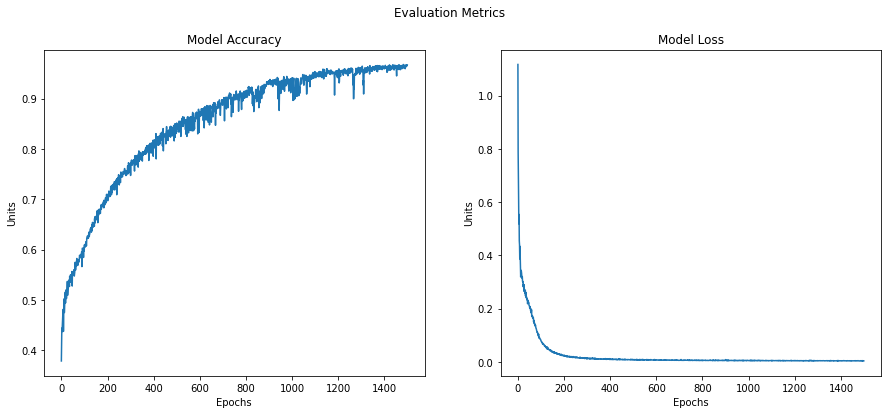

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Evaluation Metrics')
fig.set_size_inches(15, 6)

ax1.plot(history.history['accuracy'])
ax1.title.set_text('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Units')

ax2.plot(history.history['loss'])
ax2.title.set_text('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Units')

plt.show()

In [26]:
checkpoint_path = f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/checkpoint.h5"
model.save(checkpoint_path)

In [27]:
for county in county_name:
  demo_data = data[data['COUNTY_NAME'] == county]
  demo_data = demo_data[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TEST', 'Population', 'Area', 'Population Density']]
  demo_data = demo_data.tail(time_steps + 1)

  for day in range(NO_OF_DAYS_TO_PREDICT):
    demo_X_test, demo_y_test = create_dataset(demo_data[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TEST', 'Population', 'Area', 'Population Density']].tail(time_steps + 1), 
                                                        demo_data[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TEST']].tail(time_steps + 1), time_steps)
    
    predictions = np.concatenate((model.predict(demo_X_test), np.zeros((1, 3))), axis = 1)

    predictions[0,3] = np.array(demo_data['Population'])[0]
    predictions[0,4] = np.array(demo_data['Area'])[0]
    predictions[0,5] = np.array(demo_data['Population Density'])[0]

    demo_data = pd.DataFrame(np.concatenate((demo_data, predictions), axis = 0))
    demo_data.columns = ['COVID_COUNT', 'COVID_DEATHS', 'COVID_TEST', 'Population', 'Area', 'Population Density']

  transformed_demo_data = np.intc(scaler.inverse_transform(demo_data))
  demo_data['COVID_COUNT'] = transformed_demo_data[:, 0]
  demo_data['COVID_DEATHS'] = transformed_demo_data[:, 1]
  demo_data['COVID_TEST'] = transformed_demo_data[:, 2]
  demo_data['Population'] = transformed_demo_data[:, 3]
  demo_data['Area'] = transformed_demo_data[:, 4]
  demo_data['Population Density'] = transformed_demo_data[:, 5]

  demo_data = demo_data[['COVID_COUNT', 'COVID_DEATHS', 'COVID_TEST']]
  date_data = data[['DATE']]
  date_data = date_data.tail(time_steps + 6)
  date_data['DATE'] = pd.to_datetime(date_data['DATE']).apply(pd.DateOffset(5))

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  fig.suptitle('COVID FORECASTING for ' + county + ' County')
  fig.set_size_inches(24, 6)
  plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
  plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
  plt.setp(ax3.xaxis.get_majorticklabels(), rotation=90)

  ax1.plot(date_data, demo_data['COVID_COUNT'], linestyle='-', marker='o', color = 'red', label = 'COVID CASES')
  ax1.grid(True)
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Case Count')
  ax1.legend()

  ax2.plot(date_data, demo_data['COVID_DEATHS'], linestyle='-', marker='o', color = 'blue', label = 'COVID DEATHS')
  ax2.grid(True)
  ax2.set_xlabel('Date')
  ax2.set_ylabel('Death Count')
  ax2.legend()

  ax3.plot(date_data, demo_data['COVID_TEST'], linestyle='-', marker='o', color = 'green', label = 'COVID TEST')
  ax3.grid(True)
  ax3.set_xlabel('Date')
  ax3.set_ylabel('Test Count')
  ax3.legend()
  # plt.show()

  fig.savefig(f"{getcwd()}/drive/My Drive/Colab Notebooks/COVID forecasting/output images/"+county+".png", bbox_inches='tight')
  plt.close()